# Imports

In [2]:
import numpy as np
import networkx as nx
import plotly.graph_objects as go 
import gudhi as gd
import matplotlib.pyplot as plt

# Functions

In [4]:
#Inputs: ts - a 2D np array of any shape. Probably a time series. 
# b - the number of bins in each dimension
#Output: bins - A dictionary of arrays that contains the boundaries of the bins in each dimension

def get_bins(ts,b):
    d,n = ts.shape
    bins = {}
    for i in range(d):
        top = max(ts[i,:])
        bot = min(ts[i,:])
        step = (top - bot)/b
        ibins = []
        for j in range(b+1):
            ibins.append(bot+j*step)
        bins[i] = ibins
    return bins

In [5]:
#Inputs: ts - time series
#bins - the partition of each dimension into its bins
#b - number of bins in each dimension

#Output: binseq - a 1D array the length of ts that lists which bin each entry in the time series is in

def bin_sequence(ts, bins, b):
    d,n = ts.shape
    binseq = np.zeros((n))
    for i in range(n):
        bin_n = 0
        for j in range(d):
            k = 1
            while k <= b:
                if ts[j,i] <= bins[j][k]:
                    bin_n += (k-1)*(b**j)
                    k = b + 1
                else: 
                    k = k + 1 
        binseq[i] = bin_n

    return binseq

In [6]:
#inputs: bin-seq - the bin sequence of the time series
#outputs: A - the adjacency matrix
# vertices - the list of vertices, enumerated as bin number

def adjacency(bin_seq, prob = False):
    vertices, counts = np.unique(bin_seq, return_counts=True)
    order = len(vertices)
    A = np.zeros((order,order))
    for i in range(len(bin_seq)-1):
        A[np.where(vertices == bin_seq[i]),np.where(vertices == bin_seq[i+1])] += 1
    if prob:
        A[:,i] = A[:,i]/np.sum(A[:,i])
    return A, vertices, counts

In [11]:
# inputs: A - the adjacency matrix
# vertices - the list of vertices, which are the bin numbers
# loops - whether or not to keep the self-loops in the graph, I am going to do something with this eventually when I include some sort of markovian random walk diffusion distance 
#Output: G - a networkx digraph

def digraph(A, vertices, counts, loops: bool):
    if loops == False:
        np.fill_diagonal(A,0)
        G = nx.DiGraph(A)
    elif loops == True:
        G = nx.DiGraph(A)
    for i in range(len(G.nodes)):
       G.nodes[i]['bin'] = vertices[i]
       G.nodes[i]['count'] = counts[i]

    return G

In [13]:
def bin_centers(bins, b):
    bin_cent = np.zeros((b**3,3))
    for k in range(b):
        for j in range(b):
            for i in range(b):
                bin_cent[k*b**2 + j*b + i,0] += np.mean(bins[0][i:i+2]) 
                bin_cent[k*b**2 + j*b + i,1] += np.mean(bins[1][j:j+2]) 
                bin_cent[k*b**2 + j*b + i,2] += np.mean(bins[2][k:k+2]) 

    return bin_cent

In [15]:
#Inputs: G - a networkx graph
# method - the way you want to measure distance on the graph
# Outputs: D - a distance matrix

def distance_matrix(G, method = 'unweighted_shortest_path'):
    if method == 'unweighted_shortest_path':
        lengths = dict(nx.all_pairs_shortest_path_length(G))
        D = np.full((len(lengths),len(lengths)),1000,dtype=float) # was -1 default
        for key in lengths:
            for item in lengths[key]:
                    D[key,item] = lengths[key][item]
    
    if method == 'probabilistic': #since I doubt we are doing this in this paper, I haven't checked exactly if this is right
        w = nx.get_edge_attributes(G,'weight')
        for key in w:
            w[key] = 1/w[key]
        nx.set_edge_attributes(G,w,name='weight')
        lengths = dict(nx.all_pairs_dijkstra_path_length(G))
        D = np.full((len(lengths),len(lengths)),1000,dtype=float) # was -1 default
        for key in lengths:
            for item in lengths[key]:
                if lengths[key][item] != 0:
                    D[key,item] = lengths[key][item]
                elif lengths[key][item] == 0:
                    D[key,item] = 0

    if method == 'weighted_shortest_path':
        lengths = dict(nx.all_pairs_dijkstra_path_length(G))
        D = np.full((len(lengths),len(lengths)),1000,dtype=float) # was -1 default
        for key in lengths:
            for item in lengths[key]:
                if lengths[key][item] != 0:
                    D[key,item] = lengths[key][item]
                elif lengths[key][item] == 0:
                    D[key,item] = 0

    return D

In [17]:
# This cell is copy-pasted from pyDowker
# by Niklas Hellmer and Jan Spalinski, but only the portion
# that's relevant to our project.
# See https://github.com/nihell/pyDowker


from gudhi import SimplexTree
import numpy as np

class DowkerComplex:
    """
    Class MNeighborComplex. Constructs Dowker's simplicial complex for a relation.
    Filtrations can be added using filtered relations, or total weight, or combining both into a bifiltration.
    """

    def __init__(self, rel_matrix, max_filtration=float('inf')) -> None:
        """_summary_
        Constructor for the filtered Dowker complex from the relations given by sublevels of the matrix rel_matrix.
        The vertices in the complex will correspond to the rows of the matrix.
        
        Parameters
        ----------
        rel_matrix (Sequence[Sequence[float]]): distance matrix (full square or lower triangular).
        max_filtration (float): specifies the maximal filtration value to be considered.      
        """
        self.rel_matrix = rel_matrix
        self.st = None
        
        
     

    def create_simplex_tree(self, 
                            max_dimension, 
                            filtration = 'None', 
                            m=1, 
                            level = 0, 
                            max_filtration = np.inf):
        """
            Creates a gudhi simplex tree storing a skeleton of the (filtered) simpicial complex.
            Uses recursive algorithm with nummpy arrays, fast for small datasets but worse runtime and memory complexity.


        Parameters
        ----------
        max_dimension : int
            Dimension of the skeleton to compute.
        filtration : str, optional
            valid values: "Sublevel", "TotalWeight", "None".
            "Sublevel" takes the filtration of relations by sublevels of the matrix.
            "Total weight" takes the filtration by sublevels of the negative total weight function.
            By default 'None'
        m : int, optional
            restriction to this superlevel of total weight (this is only used if filtration!="TotalWeight"); m=1 corresponds to the whole Dowker complex, by default 1
        level : int, optional
            restriction to this sublevel of the matrix as relation (this is only used if filtration!="Sublevel"), by default 0
        max_filtration : float, optional
            cutoff for the filtration (only used if filtration="Sublevel"), by default np.inf

        Returns
        -------
        gudhi.SimplexTree
            The simplex tree storing the (filtered) simplicial complex
        """
        
        self.st=SimplexTree()


        LAMBDA = self.rel_matrix
        num_points=len(LAMBDA)
        
        if filtration == "Sublevel":
            if LAMBDA.dtype != np.float64:
                raise TypeError("Only float arrays are allowed with sublevel filtration") 
            def append_upper_cofaces(sigma, r, witness_values):
                if r > max_filtration:
                    return
                self.st.insert(sigma,r)
                if len(sigma)<=max_dimension:
                    for j in range(np.max(sigma)+1,num_points):
                        tau = sigma+[j]

                        j_witness_values=LAMBDA[j,:]
                        common_witness_values = np.maximum(j_witness_values,witness_values)
                        new_r = np.partition(common_witness_values, m-1)[m-1]
                        append_upper_cofaces(tau, new_r, common_witness_values)

            for k in range(num_points-1,-1,-1):
                witness_values = LAMBDA[k,:]
                r_new = np.partition(witness_values, m-1)[m-1]
                append_upper_cofaces([k],r_new,witness_values)
            return self.st
        
        elif filtration == "TotalWeight":
            if LAMBDA.dtype != np.bool_:
                LAMBDA = LAMBDA <= level

            def append_upper_cofaces(sigma, witnesses):
                
                self.st.insert(sigma,-np.sum(witnesses))
                if len(sigma)<=max_dimension:
                    for j in range(np.max(sigma)+1,num_points):
                        tau = sigma+[j]
                        j_witnesses=LAMBDA[j,:]
                        common_witnesses = np.logical_and(j_witnesses,witnesses)
                        if np.sum(common_witnesses>0):
                            append_upper_cofaces(tau, common_witnesses)

            for k in range(num_points-1,-1,-1):
                witnesses = LAMBDA[k,:]
                append_upper_cofaces([k], witnesses)
            return self.st

        elif filtration == "None":
            if LAMBDA.dtype != np.bool_:
                LAMBDA = LAMBDA <= level

            def append_upper_cofaces(sigma, witnesses):
                if len(witnesses)<m:
                    return
                self.st.insert(sigma)
                if len(sigma)<=max_dimension:
                    for j in range(np.max(sigma)+1,num_points):
                        tau = sigma+[j]
                        j_witnesses=LAMBDA[j,:]
                        common_witnesses = np.logical_and(j_witnesses,witnesses)
                        if len(common_witnesses>0):
                            append_upper_cofaces(tau, common_witnesses)

            for k in range(num_points-1,-1,-1):
                witnesses = LAMBDA[k,:]
                append_upper_cofaces([k], witnesses)
            return self.st
        
        else:
            raise Exception("filtration parameter must be one of 'Sublevel', 'TotalWeight', 'None'")

In [19]:
def weight_graph(G, weights, smallest, biggest):


    edges = [e for e in G.edges]

    for e in edges:
        source = e[0]
        target = e[1]
        G[source][target]['weight'] = weights(smallest, biggest)

    return G

# For our experiments, we also need to generate synthetic cycle and figure eight graphs, with various directions and weights

## Unweighted Consistently Oriented Cycle

In [23]:
# Create cycle graph using networkx
cycleG = nx.cycle_graph(6, create_using=nx.DiGraph)

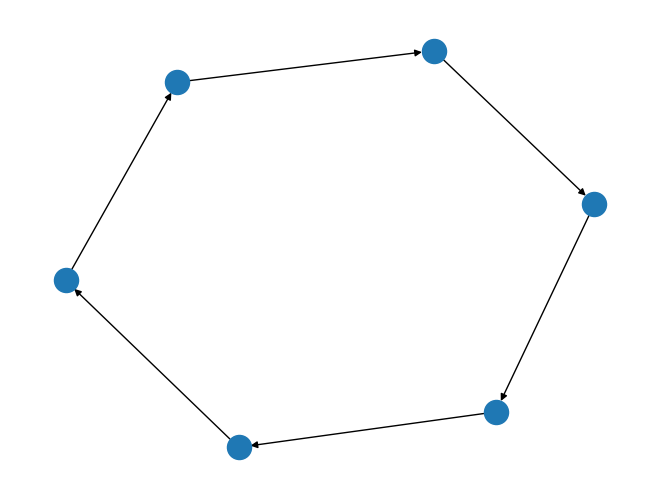

In [25]:
# Draw cycle graph
nx.draw(cycleG)

In [27]:
Dcycle = distance_matrix(cycleG)

In [29]:
cyclecomplex = DowkerComplex(Dcycle).create_simplex_tree(filtration='Sublevel', max_dimension=2)

In [31]:
dgmcycle = cyclecomplex.persistence()

In [33]:
dgmcycle

[(1, (1.0, 3.0)),
 (0, (0.0, inf)),
 (0, (0.0, 1.0)),
 (0, (0.0, 1.0)),
 (0, (0.0, 1.0)),
 (0, (0.0, 1.0)),
 (0, (0.0, 1.0))]

## Weighted Consistently Oriented Cycle

In [36]:
cycleG = nx.cycle_graph(6, create_using=nx.DiGraph)

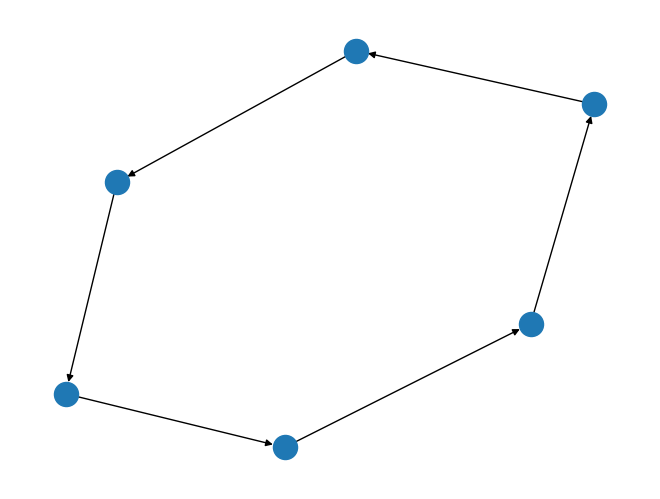

In [38]:
nx.draw(cycleG)

In [40]:
weightedcycleG = weight_graph(cycleG, np.random.randint, 1, 10)

{(0, 1): Text(0.6366301180372642, -0.27099462280487363, '8'),
 (1, 2): Text(0.5071068455909393, 0.43638905587058185, '5'),
 (2, 3): Text(-0.0668597147746195, 0.8799914206384856, '8'),
 (3, 4): Text(-0.7076687211719602, 0.30209865056885676, '1'),
 (4, 5): Text(-0.5697712916800547, -0.6090046290365472, '3'),
 (5, 0): Text(0.2005546690141522, -0.738486852057733, '8')}

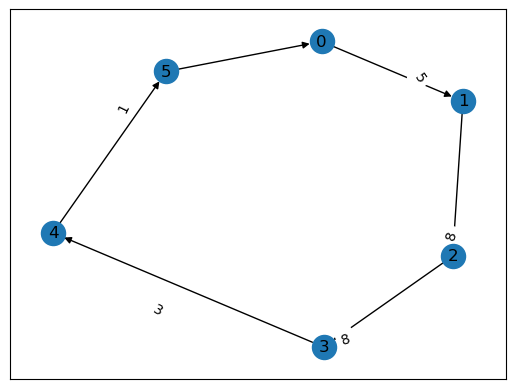

In [42]:
nx.draw_networkx(weightedcycleG)
pos=nx.spring_layout(weightedcycleG)
labels = nx.get_edge_attributes(weightedcycleG,'weight')
nx.draw_networkx_edge_labels(weightedcycleG,pos,edge_labels=labels)

In [44]:
nx.get_edge_attributes(weightedcycleG, 'weight')

{(0, 1): 8, (1, 2): 5, (2, 3): 8, (3, 4): 1, (4, 5): 3, (5, 0): 8}

In [46]:
Dcycleweighted = distance_matrix(weightedcycleG, 'weighted_shortest_path')

In [48]:
Dcycleweighted

array([[ 0.,  8., 13., 21., 22., 25.],
       [25.,  0.,  5., 13., 14., 17.],
       [20., 28.,  0.,  8.,  9., 12.],
       [12., 20., 25.,  0.,  1.,  4.],
       [11., 19., 24., 32.,  0.,  3.],
       [ 8., 16., 21., 29., 30.,  0.]])

In [50]:
weightedcyclecomplex = DowkerComplex(Dcycleweighted).create_simplex_tree(filtration='Sublevel', max_dimension=2)

In [52]:
dgmweightedcycle = weightedcyclecomplex.persistence()

In [54]:
dgmweightedcycle

[(1, (8.0, 17.0)),
 (0, (0.0, inf)),
 (0, (0.0, 8.0)),
 (0, (0.0, 8.0)),
 (0, (0.0, 5.0)),
 (0, (0.0, 3.0)),
 (0, (0.0, 1.0))]

## Not Consistently Oriented Cycle

In [57]:
notcycleG = nx.cycle_graph(6, create_using=nx.DiGraph)

notcycleG.remove_edge(3,4)
notcycleG.remove_edge(4,5)
notcycleG.remove_edge(5,0)
notcycleG.add_edge(4,3)
notcycleG.add_edge(5,4)
notcycleG.add_edge(0,5)


In [59]:
Dnotcycle = distance_matrix(notcycleG)

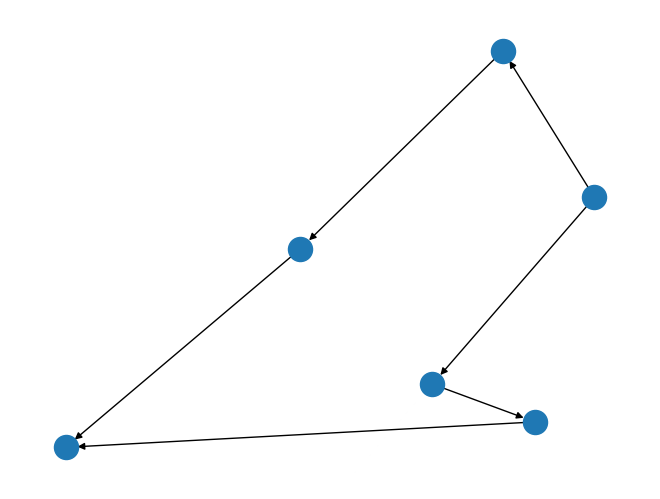

In [61]:
nx.draw(notcycleG)

In [63]:
Dnotcycle

array([[   0.,    1.,    2.,    3.,    2.,    1.],
       [1000.,    0.,    1.,    2., 1000., 1000.],
       [1000., 1000.,    0.,    1., 1000., 1000.],
       [1000., 1000., 1000.,    0., 1000., 1000.],
       [1000., 1000., 1000.,    1.,    0., 1000.],
       [1000., 1000., 1000.,    2.,    1.,    0.]])

In [65]:
notcyclecomplex = DowkerComplex(Dnotcycle).create_simplex_tree(filtration='Sublevel', max_dimension=2)

In [67]:
dgmnotcycle = notcyclecomplex.persistence()

In [69]:
dgmnotcycle

[(1, (1.0, 3.0)),
 (0, (0.0, inf)),
 (0, (0.0, 1.0)),
 (0, (0.0, 1.0)),
 (0, (0.0, 1.0)),
 (0, (0.0, 1.0)),
 (0, (0.0, 1.0))]

## Not Consistently Oriented, Weighted Cycles

### One source, one sink

In [73]:
# Example with 6 vertices, source at 0, sink at 3
numVerts = 6
notcycleG = nx.cycle_graph(numVerts, create_using=nx.DiGraph)
wtnotcycleG = weight_graph(notcycleG, np.random.randint, 1, 10)

wtnotcycleG.remove_edge(3,4)
wtnotcycleG.remove_edge(4,5)
wtnotcycleG.remove_edge(5,0)
# right now, generating new random weights, but could keep originally generated weights
wtnotcycleG.add_edge(4, 3, weight=np.random.randint(1,10))
wtnotcycleG.add_edge(5,4, weight=np.random.randint(1,10))
wtnotcycleG.add_edge(0,5, weight=np.random.randint(1,10))


{(0, 1): Text(0.1418753420671981, -0.773769308857456, '7'),
 (0, 5): Text(0.4406749040580342, -0.6032368657283744, '6'),
 (1, 2): Text(-0.036018383733053216, 0.08842836700713164, '1'),
 (2, 3): Text(-0.19361688612987726, 0.741162622010146, '5'),
 (4, 3): Text(-0.40465689682135997, 0.51479682982442, '7'),
 (5, 4): Text(0.05174045967151586, 0.03260552483975532, '9')}

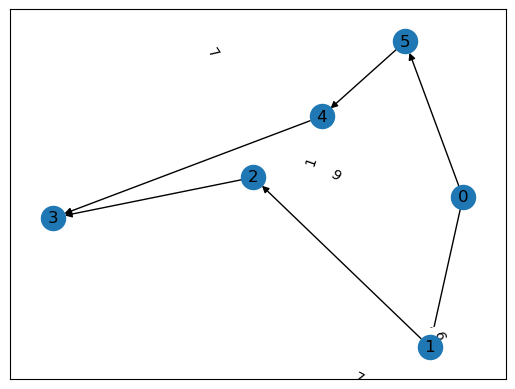

In [75]:
nx.draw_networkx(wtnotcycleG)
pos=nx.spring_layout(wtnotcycleG)
labels = nx.get_edge_attributes(wtnotcycleG,'weight')
nx.draw_networkx_edge_labels(wtnotcycleG,pos,edge_labels=labels)

In [77]:
DwtnotcycleG = distance_matrix(wtnotcycleG, method='weighted_shortest_path')

In [79]:
DwtnotcycleG

array([[   0.,    7.,    8.,   13.,   15.,    6.],
       [1000.,    0.,    1.,    6., 1000., 1000.],
       [1000., 1000.,    0.,    5., 1000., 1000.],
       [1000., 1000., 1000.,    0., 1000., 1000.],
       [1000., 1000., 1000.,    7.,    0., 1000.],
       [1000., 1000., 1000.,   16.,    9.,    0.]])

In [81]:
wtnotcyclecomplex = DowkerComplex(DwtnotcycleG).create_simplex_tree(filtration='Sublevel', max_dimension=2)

In [83]:
dgmwtnotcycle = wtnotcyclecomplex.persistence()

In [85]:
dgmwtnotcycle

[(1, (9.0, 15.0)),
 (0, (0.0, inf)),
 (0, (0.0, 7.0)),
 (0, (0.0, 7.0)),
 (0, (0.0, 6.0)),
 (0, (0.0, 5.0)),
 (0, (0.0, 1.0))]

### Lots of sources
<p>Even number of vertices; every other vertex a source</p>
<p>Should have one cycle persist indefinitely.</p>

In [88]:
# Example with numVerts vertices, every other is source/sink
numVerts = 16 # make even for alternating
G = nx.cycle_graph(numVerts, create_using=nx.DiGraph)
G = weight_graph(G, np.random.randint, 1, 10)

weightDict = nx.get_edge_attributes(G, 'weight')

for k in range(1, numVerts+1, 2):
    node1 = k
    node2 = (k+1)%numVerts
    
    current_weight = weightDict[(node1, node2)]
    
    G.remove_edge(node1, node2)
    G.add_edge(node2, node1, weight=current_weight)

{(0, 1): Text(-0.2633728403916553, 0.53583392986601, '8'),
 (0, 15): Text(0.06850142023025607, -0.40593989031838085, '3'),
 (2, 3): Text(0.6831870565850244, 0.3702662623903794, '5'),
 (2, 1): Text(0.017823830067607904, 0.6948304350371994, '2'),
 (4, 5): Text(0.7663713161574224, -0.4455257451675436, '2'),
 (4, 3): Text(0.8573070251716359, -0.005155867047883733, '1'),
 (6, 7): Text(0.6006093805134274, 0.5298897987800275, '4'),
 (6, 5): Text(0.7062030551069016, -0.24730256430567032, '4'),
 (8, 9): Text(-0.14688183274191813, -0.5850059323051389, '8'),
 (8, 7): Text(0.252864172243364, 0.2798876458587587, '1'),
 (10, 11): Text(-0.812238652611572, -0.4364429956754716, '9'),
 (10, 9): Text(-0.43792378948182287, -0.6859015164491505, '9'),
 (12, 13): Text(-0.8491208138918578, 0.5758348503013797, '4'),
 (12, 11): Text(-0.9509504239744788, -0.027707350617460103, '5'),
 (14, 15): Text(0.021450281687372286, -0.5448254680695123, '5'),
 (14, 13): Text(-0.513820791178855, 0.39728529059108, '4')}

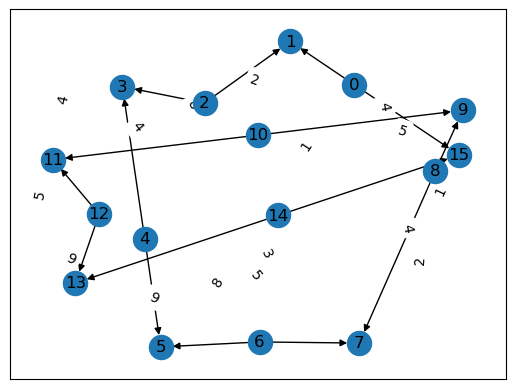

In [90]:
nx.draw_networkx(G)
pos=nx.spring_layout(G)
labels = nx.get_edge_attributes(G,'weight')
nx.draw_networkx_edge_labels(G,pos,edge_labels=labels)

In [92]:
DwtnotcycleG = distance_matrix(G, method='weighted_shortest_path')

In [94]:
DwtnotcycleG

array([[   0.,    8., 1000., 1000., 1000., 1000., 1000., 1000., 1000.,
        1000., 1000., 1000., 1000., 1000., 1000.,    3.],
       [1000.,    0., 1000., 1000., 1000., 1000., 1000., 1000., 1000.,
        1000., 1000., 1000., 1000., 1000., 1000., 1000.],
       [1000.,    2.,    0.,    5., 1000., 1000., 1000., 1000., 1000.,
        1000., 1000., 1000., 1000., 1000., 1000., 1000.],
       [1000., 1000., 1000.,    0., 1000., 1000., 1000., 1000., 1000.,
        1000., 1000., 1000., 1000., 1000., 1000., 1000.],
       [1000., 1000., 1000.,    1.,    0.,    2., 1000., 1000., 1000.,
        1000., 1000., 1000., 1000., 1000., 1000., 1000.],
       [1000., 1000., 1000., 1000., 1000.,    0., 1000., 1000., 1000.,
        1000., 1000., 1000., 1000., 1000., 1000., 1000.],
       [1000., 1000., 1000., 1000., 1000.,    4.,    0.,    4., 1000.,
        1000., 1000., 1000., 1000., 1000., 1000., 1000.],
       [1000., 1000., 1000., 1000., 1000., 1000., 1000.,    0., 1000.,
        1000., 1000., 1000

In [96]:
wtnotcyclecomplex = DowkerComplex(DwtnotcycleG).create_simplex_tree(filtration='Sublevel', max_dimension=2)

In [98]:
dgmwtnotcycle = wtnotcyclecomplex.persistence()

In [100]:
dgmwtnotcycle # One cycle persists indefinitely!

[(1, (9.0, 1000.0)),
 (0, (0.0, inf)),
 (0, (0.0, 9.0)),
 (0, (0.0, 8.0)),
 (0, (0.0, 8.0)),
 (0, (0.0, 5.0)),
 (0, (0.0, 5.0)),
 (0, (0.0, 5.0)),
 (0, (0.0, 4.0)),
 (0, (0.0, 4.0)),
 (0, (0.0, 4.0)),
 (0, (0.0, 4.0)),
 (0, (0.0, 3.0)),
 (0, (0.0, 2.0)),
 (0, (0.0, 2.0)),
 (0, (0.0, 1.0)),
 (0, (0.0, 1.0))]

### Two opposing sources

In [103]:
# Example with 22 vertices, sources at 0 and 11, sinks at 4 and 18
numVerts = 22
source1 = 0
sink1 = 4
source2 = 11
sink2 = 18
Gtwosource = nx.cycle_graph(numVerts, create_using=nx.DiGraph)
Gtwosource = weight_graph(Gtwosource, np.random.randint, 1, 10)

weightDict = nx.get_edge_attributes(Gtwosource, 'weight')

# Swap direction between sink1 and source2
for k in range(sink1, source2, 1):
    node1 = k
    node2 = (k+1)%numVerts
    
    current_weight = weightDict[(node1, node2)] # keeping current weights; could generate new random weights
    
    Gtwosource.remove_edge(node1, node2)
    Gtwosource.add_edge(node2, node1, weight=current_weight)

# Swap direction between sink2 and source1
for k in range(sink2, numVerts, 1):
    node1 = k
    node2 = (k+1)%numVerts
    
    current_weight = weightDict[(node1, node2)] # keeping current weights; could generate new random weights
    
    Gtwosource.remove_edge(node1, node2)
    Gtwosource.add_edge(node2, node1, weight=current_weight)


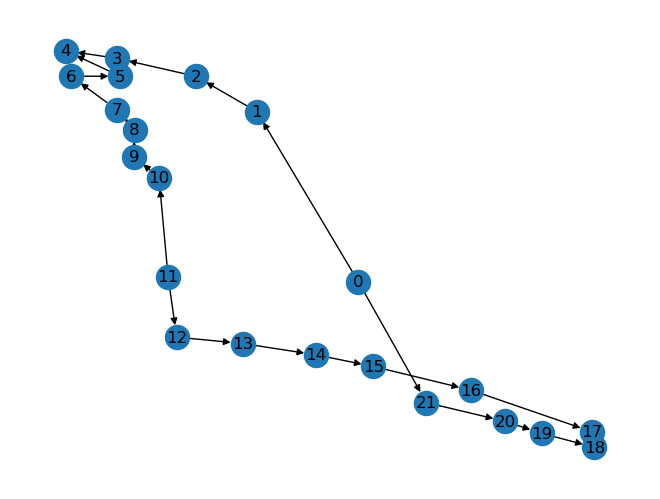

In [105]:
nx.draw(Gtwosource, with_labels="True")

{(0, 1): Text(0.3426647783704839, -0.10082096582567868, '1'),
 (0, 21): Text(-0.258394707770669, -0.02852094488358148, '2'),
 (1, 2): Text(0.7657260371488694, -0.10502880262079084, '5'),
 (2, 3): Text(0.8889866880947312, -0.03628691616698054, '3'),
 (3, 4): Text(0.9874988818406083, 0.02027454795441974, '5'),
 (5, 4): Text(0.8540559185556582, -0.016748051111673545, '6'),
 (6, 5): Text(0.635662262439632, -0.08094817295165102, '5'),
 (7, 6): Text(0.511369919816395, -0.11586582474011564, '8'),
 (8, 7): Text(0.4128416578393008, -0.1430761119305517, '8'),
 (9, 8): Text(0.2924869691326142, -0.19284030131950913, '1'),
 (10, 9): Text(0.21092527672629768, -0.23815548289248012, '7'),
 (11, 12): Text(-0.18061357154870272, 0.15579396462851358, '8'),
 (11, 10): Text(0.03884434662109704, -0.11142491860494141, '3'),
 (12, 13): Text(-0.3277538067220487, 0.26982367654357864, '5'),
 (13, 14): Text(-0.4534843348941725, 0.26198781808196414, '4'),
 (14, 15): Text(-0.5648605519064662, 0.2097172397354441, '9'

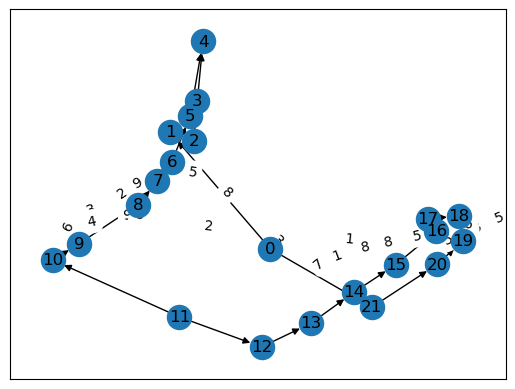

In [107]:
nx.draw_networkx(Gtwosource)
pos=nx.spring_layout(Gtwosource)
labels = nx.get_edge_attributes(Gtwosource,'weight')
nx.draw_networkx_edge_labels(Gtwosource,pos,edge_labels=labels)

In [109]:
Dtwosource = distance_matrix(Gtwosource, method='weighted_shortest_path')
complextwosource = DowkerComplex(Dtwosource).create_simplex_tree(filtration='Sublevel', max_dimension=2)
dgmtwosource = complextwosource.persistence()
dgmtwosource

[(1, (9.0, 38.0)),
 (0, (0.0, inf)),
 (0, (0.0, 9.0)),
 (0, (0.0, 8.0)),
 (0, (0.0, 8.0)),
 (0, (0.0, 8.0)),
 (0, (0.0, 7.0)),
 (0, (0.0, 6.0)),
 (0, (0.0, 6.0)),
 (0, (0.0, 5.0)),
 (0, (0.0, 5.0)),
 (0, (0.0, 5.0)),
 (0, (0.0, 5.0)),
 (0, (0.0, 5.0)),
 (0, (0.0, 4.0)),
 (0, (0.0, 4.0)),
 (0, (0.0, 3.0)),
 (0, (0.0, 3.0)),
 (0, (0.0, 3.0)),
 (0, (0.0, 2.0)),
 (0, (0.0, 2.0)),
 (0, (0.0, 1.0)),
 (0, (0.0, 1.0))]

### One source and one sink source, one edge with large weight

In [166]:
# Example with 12 vertices, sink at 0, source at 6, large weight on edge (5,4)
numVerts = 12
notcycleG = nx.cycle_graph(numVerts, create_using=nx.DiGraph)
Glrgwt = weight_graph(notcycleG, np.random.randint, 1, 10)

source = 6
sink = 0

weightDict = nx.get_edge_attributes(Glrgwt, 'weight')

# Swap direction between sink1 and source2
for k in range(sink, source, 1):
    node1 = k
    node2 = (k+1)%numVerts
    
    current_weight = weightDict[(node1, node2)] # keeping current weights; could generate new random weights
    
    Glrgwt.remove_edge(node1, node2)
    Glrgwt.add_edge(node2, node1, weight=current_weight)

# Replace one edge with large weight
Glrgwt.remove_edge(5,4)
Glrgwt.add_edge(5,4,weight=200)

{(1, 0): Text(-0.6745778329331312, -0.333953268737772, '5'),
 (2, 1): Text(-0.1932773473726861, -0.029038113650296737, '1'),
 (3, 2): Text(0.1922114644327837, 0.13223792224884678, '1'),
 (4, 3): Text(0.4911322094969581, 0.4095891047454667, '1'),
 (5, 4): Text(0.5283583959153664, 0.6664505935631424, '200'),
 (6, 7): Text(0.5636811362249801, 0.12073356640470778, '2'),
 (6, 5): Text(0.5245259492753418, 0.5566741604887449, '8'),
 (7, 8): Text(0.44565394289615523, -0.20413850065505867, '9'),
 (8, 9): Text(0.08491882807834483, -0.3052558808504834, '6'),
 (9, 10): Text(-0.39095470677388433, -0.29902972996542987, '1'),
 (10, 11): Text(-0.6945967607262604, -0.2802189500466168, '6'),
 (11, 0): Text(-0.8770910775704422, -0.4340638717632749, '4')}

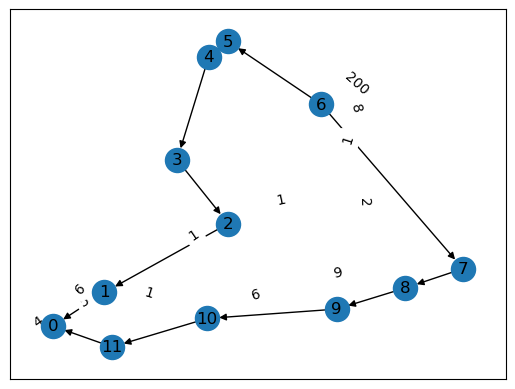

In [170]:
nx.draw_networkx(Glrgwt)
pos=nx.spring_layout(Glrgwt)
labels = nx.get_edge_attributes(Glrgwt,'weight')
nx.draw_networkx_edge_labels(Glrgwt,pos,edge_labels=labels)

In [172]:
DwtnotcycleG = distance_matrix(wtnotcycleG, method='weighted_shortest_path')

In [174]:
DwtnotcycleG

array([[ 0.,  1.,  6., 10., 11., 18., 26., 35., 39., 48., 55., 60.],
       [63.,  0.,  5.,  9., 10., 17., 25., 34., 38., 47., 54., 59.],
       [58., 59.,  0.,  4.,  5., 12., 20., 29., 33., 42., 49., 54.],
       [54., 55., 60.,  0.,  1.,  8., 16., 25., 29., 38., 45., 50.],
       [53., 54., 59., 63.,  0.,  7., 15., 24., 28., 37., 44., 49.],
       [46., 47., 52., 56., 57.,  0.,  8., 17., 21., 30., 37., 42.],
       [38., 39., 44., 48., 49., 56.,  0.,  9., 13., 22., 29., 34.],
       [29., 30., 35., 39., 40., 47., 55.,  0.,  4., 13., 20., 25.],
       [25., 26., 31., 35., 36., 43., 51., 60.,  0.,  9., 16., 21.],
       [16., 17., 22., 26., 27., 34., 42., 51., 55.,  0.,  7., 12.],
       [ 9., 10., 15., 19., 20., 27., 35., 44., 48., 57.,  0.,  5.],
       [ 4.,  5., 10., 14., 15., 22., 30., 39., 43., 52., 59.,  0.]])

In [176]:
wtnotcyclecomplex = DowkerComplex(DwtnotcycleG).create_simplex_tree(filtration='Sublevel', max_dimension=2)

In [178]:
dgmwtnotcycle = wtnotcyclecomplex.persistence()

In [180]:
dgmwtnotcycle

[(1, (9.0, 33.0)),
 (0, (0.0, inf)),
 (0, (0.0, 9.0)),
 (0, (0.0, 8.0)),
 (0, (0.0, 7.0)),
 (0, (0.0, 7.0)),
 (0, (0.0, 5.0)),
 (0, (0.0, 5.0)),
 (0, (0.0, 4.0)),
 (0, (0.0, 4.0)),
 (0, (0.0, 4.0)),
 (0, (0.0, 1.0)),
 (0, (0.0, 1.0))]